# Phase 5: Baseline Model (LightGBM)

Train a LightGBM regressor on 14 tabular features to establish a performance floor.
Can we predict furnisher score from area + shape + room type alone?

**Features**: 5 numeric (area, aspect_ratio, n_vertices, door_rel_x, door_rel_y) + 9 one-hot (room type) = 14  
**Target**: score (0â€“100)  
**Split**: apartment-level stratified 80/10/10  

**Plan**: [plans/05-baseline-model.md](../plans/05-baseline-model.md) | **Naive MAE**: 37.48

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import wandb
import joblib
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score, accuracy_score

from furnisher_surrogate.data import load_apartments, assign_splits, get_rooms_by_split, ROOM_TYPES
from furnisher_surrogate.features import extract_feature_matrix, extract_scores, FEATURE_NAMES

plt.rcParams.update({"figure.dpi": 120, "figure.facecolor": "white"})

# Load and split
apartments = load_apartments()
split_map = assign_splits(apartments)
rooms = get_rooms_by_split(apartments, split_map)

print(f"Train: {len(rooms['train']):,} rooms")
print(f"Val:   {len(rooms['val']):,} rooms")
print(f"Test:  {len(rooms['test']):,} rooms")

Train: 36,702 rooms
Val:   4,584 rooms
Test:  4,594 rooms


In [2]:
# Extract features and targets
X_train = extract_feature_matrix(rooms["train"])
y_train = extract_scores(rooms["train"])
X_val = extract_feature_matrix(rooms["val"])
y_val = extract_scores(rooms["val"])
X_test = extract_feature_matrix(rooms["test"])
y_test = extract_scores(rooms["test"])

print(f"Features: {X_train.shape[1]} = {FEATURE_NAMES}")
print(f"Train: X={X_train.shape}, y={y_train.shape}")
print(f"Val:   X={X_val.shape},   y={y_val.shape}")
print(f"Test:  X={X_test.shape},  y={y_test.shape}")

assert not np.isnan(X_train).any(), "NaN in training features"
assert (X_train[:, 0] > 0).all(), "Non-positive areas in training set"

Features: 14 = ['area', 'aspect_ratio', 'n_vertices', 'door_rel_x', 'door_rel_y', 'room_type_Bedroom', 'room_type_Living room', 'room_type_Bathroom', 'room_type_WC', 'room_type_Kitchen', 'room_type_Children 1', 'room_type_Children 2', 'room_type_Children 3', 'room_type_Children 4']
Train: X=(36702, 14), y=(36702,)
Val:   X=(4584, 14),   y=(4584,)
Test:  X=(4594, 14),  y=(4594,)


## 1. Train LightGBM with Early Stopping

Use `lgb.cv()` with 5-fold cross-validation to find optimal number of boosting rounds,
then retrain on the full training set.

In [3]:
# W&B init
config = {
    "model": "LightGBM",
    "n_estimators": 500,
    "learning_rate": 0.05,
    "max_depth": 6,
    "num_leaves": 31,
    "min_child_samples": 20,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42,
    "n_features": X_train.shape[1],
    "train_rooms": len(y_train),
    "val_rooms": len(y_val),
    "test_rooms": len(y_test),
    "naive_mae": 37.48,
}

run = wandb.init(
    project="furnisher-surrogate",
    group="baseline",
    name="lgbm-v1",
    config=config,
    tags=["baseline", "lightgbm", "phase5"],
)

wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from C:\Users\MartinBielik\_netrc.


wandb: Currently logged in as: martin-bielik (infau) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: setting up run 3t4hiefb


wandb: Tracking run with wandb version 0.25.0


wandb: Run data is saved locally in C:\Users\MartinBielik\Dev\SpatialTimber\SpatialTimber_FurnisherSurrogate\notebooks\wandb\run-20260226_145011-3t4hiefb
wandb: Run `wandb offline` to turn off syncing.


wandb: Syncing run lgbm-v1


wandb:  View project at https://wandb.ai/infau/furnisher-surrogate


wandb:  View run at https://wandb.ai/infau/furnisher-surrogate/runs/3t4hiefb


In [4]:
# LightGBM Dataset objects
dtrain = lgb.Dataset(X_train, label=y_train, feature_name=FEATURE_NAMES, free_raw_data=False)
dval = lgb.Dataset(X_val, label=y_val, feature_name=FEATURE_NAMES, free_raw_data=False)

params = {
    "objective": "regression",
    "metric": "mae",
    "learning_rate": config["learning_rate"],
    "max_depth": config["max_depth"],
    "num_leaves": config["num_leaves"],
    "min_child_samples": config["min_child_samples"],
    "subsample": config["subsample"],
    "colsample_bytree": config["colsample_bytree"],
    "seed": config["random_state"],
    "verbose": -1,
}

# Cross-validation to find optimal number of boosting rounds
# Use KFold (not StratifiedKFold) since target is continuous
from sklearn.model_selection import KFold

cv_result = lgb.cv(
    params,
    dtrain,
    num_boost_round=2000,
    folds=KFold(n_splits=5, shuffle=True, random_state=config["random_state"]),
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100),
    ],
    return_cvbooster=False,
)

optimal_rounds = len(cv_result["valid l1-mean"])
best_cv_mae = cv_result["valid l1-mean"][-1]
print(f"\nOptimal rounds: {optimal_rounds}")
print(f"Best CV MAE: {best_cv_mae:.4f}")

wandb.summary["cv/optimal_rounds"] = optimal_rounds
wandb.summary["cv/best_mae"] = best_cv_mae

C:\Users\MartinBielik\Dev\SpatialTimber\SpatialTimber_FurnisherSurrogate\.venv\Lib\site-packages\sklearn\model_selection\_split.py:87: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 50 rounds


[100]	valid's l1: 11.7875 + 0.0544036


[200]	valid's l1: 11.2304 + 0.0653403


[300]	valid's l1: 11.1566 + 0.0618394


[400]	valid's l1: 11.1373 + 0.0553431


[500]	valid's l1: 11.1346 + 0.0504558
Early stopping, best iteration is:
[457]	valid's l1: 11.1284 + 0.0493105

Optimal rounds: 457
Best CV MAE: 11.1284


In [5]:
# Train final model on full training set with optimal rounds
model = lgb.train(
    params,
    dtrain,
    num_boost_round=optimal_rounds,
    valid_sets=[dtrain, dval],
    valid_names=["train", "val"],
    callbacks=[lgb.log_evaluation(period=100)],
)

wandb.config.update({"n_estimators_actual": optimal_rounds}, allow_val_change=True)
print(f"\nTrained LightGBM with {optimal_rounds} rounds")

[100]	train's l1: 11.5314	val's l1: 11.64


[200]	train's l1: 10.7453	val's l1: 11.0284


[300]	train's l1: 10.4792	val's l1: 10.8923


[400]	train's l1: 10.3065	val's l1: 10.8812



Trained LightGBM with 457 rounds


In [6]:
# Save model
model_path = Path("../models/baseline_lgbm.joblib")
model_path.parent.mkdir(parents=True, exist_ok=True)
joblib.dump(model, model_path)
print(f"Saved model to {model_path} ({model_path.stat().st_size / 1024:.0f} KB)")

# W&B artifact
artifact = wandb.Artifact("baseline-lgbm", type="model",
                          description="LightGBM baseline regressor on 14 tabular features")
artifact.add_file(str(model_path))
run.log_artifact(artifact)

Saved model to ..\models\baseline_lgbm.joblib (1265 KB)


<Artifact baseline-lgbm>

## 2. Evaluation

Metrics on val and test sets: MAE, RMSE, RÂ², per-room-type MAE.
Also: binary fail/pass classification metrics (score=0 vs score>0).

In [7]:
def compute_metrics(y_true, y_pred, prefix=""):
    """Compute regression + classification metrics."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    # Binary fail/pass: score=0 vs score>0
    y_true_bin = (y_true > 0).astype(int)
    y_pred_bin = (y_pred > 5).astype(int)  # threshold at 5 for regression imprecision
    acc = accuracy_score(y_true_bin, y_pred_bin)
    f1 = f1_score(y_true_bin, y_pred_bin, average="binary")

    # Conditional MAE
    mask_zero = y_true == 0
    mask_nonzero = y_true > 0
    mae_zeros = mean_absolute_error(y_true[mask_zero], y_pred[mask_zero]) if mask_zero.any() else 0
    mae_nonzero = mean_absolute_error(y_true[mask_nonzero], y_pred[mask_nonzero]) if mask_nonzero.any() else 0

    p = f"{prefix}/" if prefix else ""
    return {
        f"{p}mae": mae, f"{p}rmse": rmse, f"{p}r2": r2,
        f"{p}binary_accuracy": acc, f"{p}binary_f1": f1,
        f"{p}mae_on_zeros": mae_zeros, f"{p}mae_on_nonzero": mae_nonzero,
    }

# Predictions
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

train_m = compute_metrics(y_train, y_train_pred, "train")
val_m = compute_metrics(y_val, y_val_pred, "val")
test_m = compute_metrics(y_test, y_test_pred, "test")

# Log all scalar metrics to W&B summary (no steps)
wandb.summary.update({**train_m, **val_m, **test_m})

# W&B: overall metrics as a clean table
naive = config["naive_mae"]
metrics_table = wandb.Table(
    columns=["Split", "n", "MAE", "vs Naive", "RMSE", "RÂ²",
             "Fail/Pass Acc", "Fail/Pass F1", "MAE (zeros)", "MAE (nonzero)"],
    data=[
        ["Train", len(y_train),
         round(train_m["train/mae"], 2),
         f"-{naive - train_m['train/mae']:.1f} ({(naive - train_m['train/mae'])/naive*100:.0f}%)",
         round(train_m["train/rmse"], 2), round(train_m["train/r2"], 4),
         round(train_m["train/binary_accuracy"], 4), round(train_m["train/binary_f1"], 4),
         round(train_m["train/mae_on_zeros"], 2), round(train_m["train/mae_on_nonzero"], 2)],
        ["Val", len(y_val),
         round(val_m["val/mae"], 2),
         f"-{naive - val_m['val/mae']:.1f} ({(naive - val_m['val/mae'])/naive*100:.0f}%)",
         round(val_m["val/rmse"], 2), round(val_m["val/r2"], 4),
         round(val_m["val/binary_accuracy"], 4), round(val_m["val/binary_f1"], 4),
         round(val_m["val/mae_on_zeros"], 2), round(val_m["val/mae_on_nonzero"], 2)],
        ["Test", len(y_test),
         round(test_m["test/mae"], 2),
         f"-{naive - test_m['test/mae']:.1f} ({(naive - test_m['test/mae'])/naive*100:.0f}%)",
         round(test_m["test/rmse"], 2), round(test_m["test/r2"], 4),
         round(test_m["test/binary_accuracy"], 4), round(test_m["test/binary_f1"], 4),
         round(test_m["test/mae_on_zeros"], 2), round(test_m["test/mae_on_nonzero"], 2)],
        ["Naive", len(y_test), naive, "â€”", None, None, None, None, None, None],
    ],
)
wandb.log({"overall_metrics": metrics_table}, commit=False)

print(f"{'':>8s}  {'MAE':>8s}  {'RMSE':>8s}  {'RÂ²':>8s}  {'Fail/Pass Acc':>14s}  {'F1':>6s}")
print("-" * 60)
for name, m in [("Train", train_m), ("Val", val_m), ("Test", test_m)]:
    p = name.lower()
    print(f"{name:>8s}  {m[f'{p}/mae']:8.2f}  {m[f'{p}/rmse']:8.2f}  {m[f'{p}/r2']:8.4f}  "
          f"{m[f'{p}/binary_accuracy']:14.4f}  {m[f'{p}/binary_f1']:6.4f}")
print(f"\nNaive baseline MAE: {naive:.2f}")
print(f"Improvement over naive: {naive - val_m['val/mae']:.2f} points "
      f"({(naive - val_m['val/mae']) / naive * 100:.1f}%)")

               MAE      RMSE       RÂ²   Fail/Pass Acc      F1
------------------------------------------------------------
   Train     10.21     17.44    0.8327          0.8769  0.9203
     Val     10.87     18.95    0.7949          0.8833  0.9260
    Test     11.02     19.15    0.8000          0.8744  0.9182

Naive baseline MAE: 37.48
Improvement over naive: 26.61 points (71.0%)


In [8]:
# Per-room-type metrics (full breakdown)
def per_type_metrics(rooms_list, y_pred):
    results = {}
    for rt in ROOM_TYPES:
        mask = np.array([r.room_type == rt for r in rooms_list])
        if mask.any():
            y_true_rt = extract_scores([r for r, m in zip(rooms_list, mask) if m])
            y_pred_rt = y_pred[mask]
            n = int(mask.sum())
            mae = mean_absolute_error(y_true_rt, y_pred_rt)
            rmse = float(np.sqrt(mean_squared_error(y_true_rt, y_pred_rt)))
            r2 = float(r2_score(y_true_rt, y_pred_rt)) if n > 1 else 0.0
            naive_mae = float(np.mean(np.abs(y_true_rt - y_true_rt.mean())))

            # fail/pass metrics
            y_true_bin = (y_true_rt > 0).astype(int)
            y_pred_bin = (y_pred_rt > 5).astype(int)
            n_zeros = int((y_true_rt == 0).sum())
            acc = accuracy_score(y_true_bin, y_pred_bin) if n > 0 else 0.0
            f1 = f1_score(y_true_bin, y_pred_bin, average="binary", zero_division=0)

            results[rt] = {
                "n": n, "mae": mae, "rmse": rmse, "r2": r2,
                "naive_mae": naive_mae, "n_zeros": n_zeros,
                "binary_accuracy": acc, "binary_f1": f1,
            }
    return results

val_pt = per_type_metrics(rooms["val"], y_val_pred)
test_pt = per_type_metrics(rooms["test"], y_test_pred)

# W&B: per-room-type with all metrics
room_type_table = wandb.Table(
    columns=["Room Type", "n", "n_zeros", "MAE", "vs Naive", "RMSE", "RÂ²",
             "Fail/Pass Acc", "Fail/Pass F1", "Naive MAE"],
    data=[[rt,
           test_pt[rt]["n"], test_pt[rt]["n_zeros"],
           round(test_pt[rt]["mae"], 2),
           f"-{test_pt[rt]['naive_mae'] - test_pt[rt]['mae']:.1f} ({(test_pt[rt]['naive_mae'] - test_pt[rt]['mae'])/test_pt[rt]['naive_mae']*100:.0f}%)",
           round(test_pt[rt]["rmse"], 2), round(test_pt[rt]["r2"], 4),
           round(test_pt[rt]["binary_accuracy"], 4),
           round(test_pt[rt]["binary_f1"], 4),
           round(test_pt[rt]["naive_mae"], 2)]
          for rt in ROOM_TYPES if rt in test_pt],
)
wandb.log({"per_room_type_metrics": room_type_table}, commit=False)

# Also store individual test MAEs in summary for quick comparison
for rt, d in test_pt.items():
    wandb.summary[f"test/mae_{rt}"] = d["mae"]

print(f"{'Room type':<15s}  {'n':>5s}  {'MAE':>7s}  {'RMSE':>7s}  {'RÂ²':>7s}  "
      f"{'Acc':>6s}  {'F1':>6s}  {'Naive':>6s}")
print("-" * 68)
for rt in ROOM_TYPES:
    t = test_pt.get(rt, {})
    if t:
        print(f"{rt:<15s}  {t['n']:>5d}  {t['mae']:>7.2f}  {t['rmse']:>7.2f}  {t['r2']:>7.4f}  "
              f"{t['binary_accuracy']:>6.3f}  {t['binary_f1']:>6.3f}  {t['naive_mae']:>6.2f}")

Room type            n      MAE     RMSE      RÂ²     Acc      F1   Naive
--------------------------------------------------------------------
Bedroom            744    10.29    16.19   0.8600   0.875   0.908   40.29
Living room        750    18.84    26.85   0.5986   0.799   0.883   39.13
Bathroom           833     3.14     6.44   0.9718   0.947   0.969   30.22
WC                 429    10.87    18.97   0.8247   0.865   0.904   42.62
Kitchen            833    16.89    26.73   0.6591   0.840   0.889   43.15
Children 1         494     6.61    11.77   0.9009   0.917   0.945   34.21
Children 2         286     7.48    13.17   0.8731   0.916   0.945   33.42
Children 3         162     9.48    14.88   0.8309   0.846   0.904   32.61
Children 4          63     8.97    13.36   0.8779   0.873   0.913   36.08


## 3. Diagnostic Plots

1. Predicted vs actual scatter â€” ideal model lies on diagonal
2. Residual distribution + residuals by room type

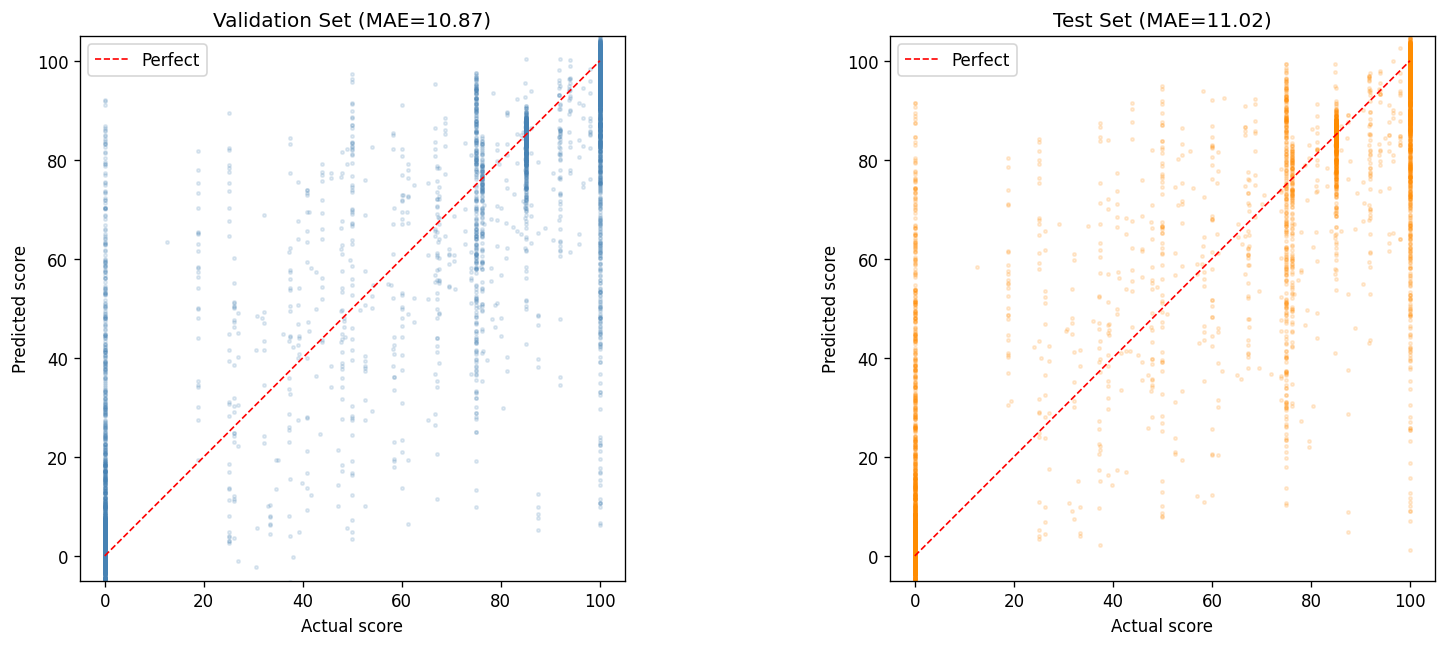

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))

for ax, y_true, y_pred, label, color in [
    (axes[0], y_val, y_val_pred, "Validation", "steelblue"),
    (axes[1], y_test, y_test_pred, "Test", "darkorange"),
]:
    mae = mean_absolute_error(y_true, y_pred)
    ax.scatter(y_true, y_pred, s=4, alpha=0.15, color=color, rasterized=True)
    ax.plot([0, 100], [0, 100], "r--", linewidth=1, label="Perfect")
    ax.set_xlabel("Actual score")
    ax.set_ylabel("Predicted score")
    ax.set_title(f"{label} Set (MAE={mae:.2f})")
    ax.legend()
    ax.set_xlim(-5, 105)
    ax.set_ylim(-5, 105)
    ax.set_aspect("equal")

plt.tight_layout()
wandb.log({"plots/pred_vs_actual": wandb.Image(fig)}, commit=False)
plt.show()

C:\Users\MartinBielik\AppData\Local\Temp\ipykernel_101232\2948172372.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(type_residuals, labels=type_labels, patch_artist=True)


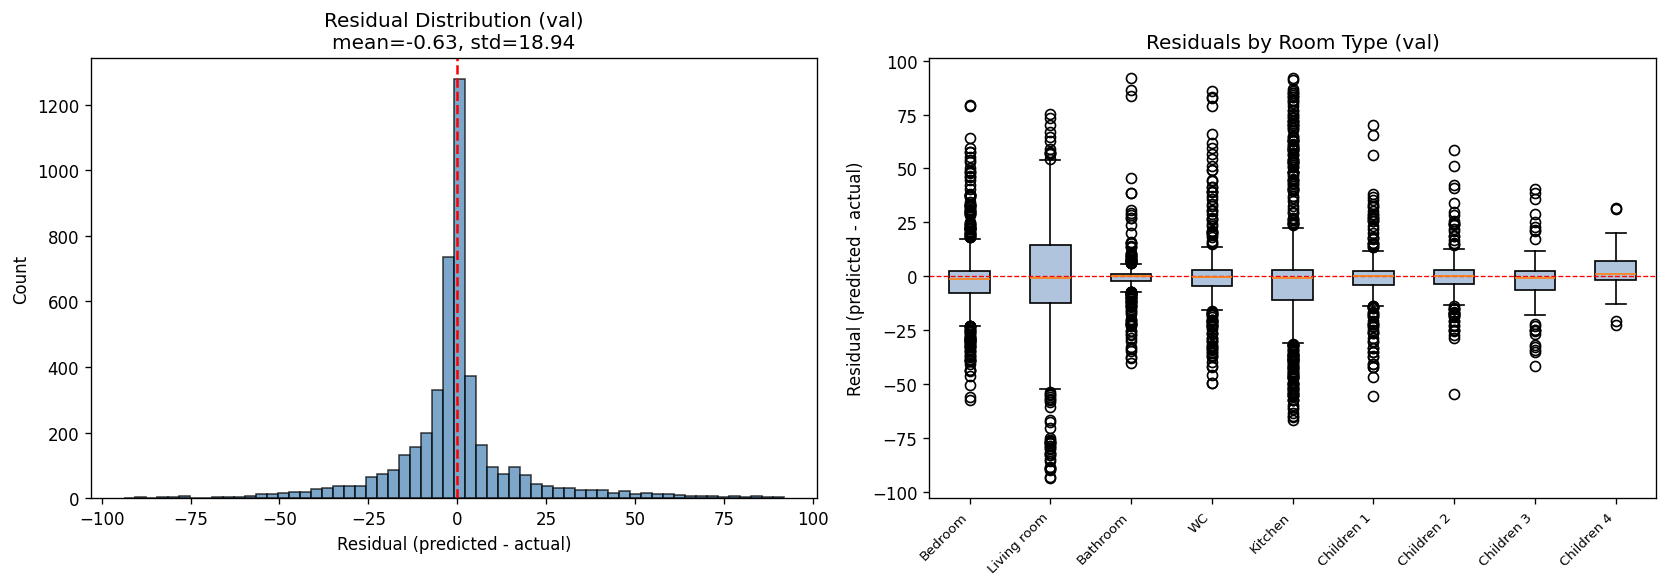

In [10]:
residuals_val = y_val_pred - y_val

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.hist(residuals_val, bins=60, edgecolor="black", alpha=0.7, color="steelblue")
ax1.axvline(0, color="red", linestyle="--")
ax1.set_xlabel("Residual (predicted - actual)")
ax1.set_ylabel("Count")
ax1.set_title(f"Residual Distribution (val)\nmean={residuals_val.mean():.2f}, std={residuals_val.std():.2f}")

type_residuals = []
type_labels = []
for rt in ROOM_TYPES:
    mask = np.array([r.room_type == rt for r in rooms["val"]])
    if mask.any():
        type_residuals.append(residuals_val[mask])
        type_labels.append(rt)

bp = ax2.boxplot(type_residuals, labels=type_labels, patch_artist=True)
for patch in bp["boxes"]:
    patch.set_facecolor("lightsteelblue")
ax2.set_xticklabels(type_labels, rotation=45, ha="right", fontsize=8)
ax2.axhline(0, color="red", linestyle="--", linewidth=0.8)
ax2.set_ylabel("Residual (predicted - actual)")
ax2.set_title("Residuals by Room Type (val)")

plt.tight_layout()
wandb.log({"plots/residuals": wandb.Image(fig)}, commit=False)
plt.show()

## 4. Feature Importance

LightGBM provides two measures:
- **Gain** â€” total information gain from splits on a feature
- **Split** â€” how many times a feature is used for splitting

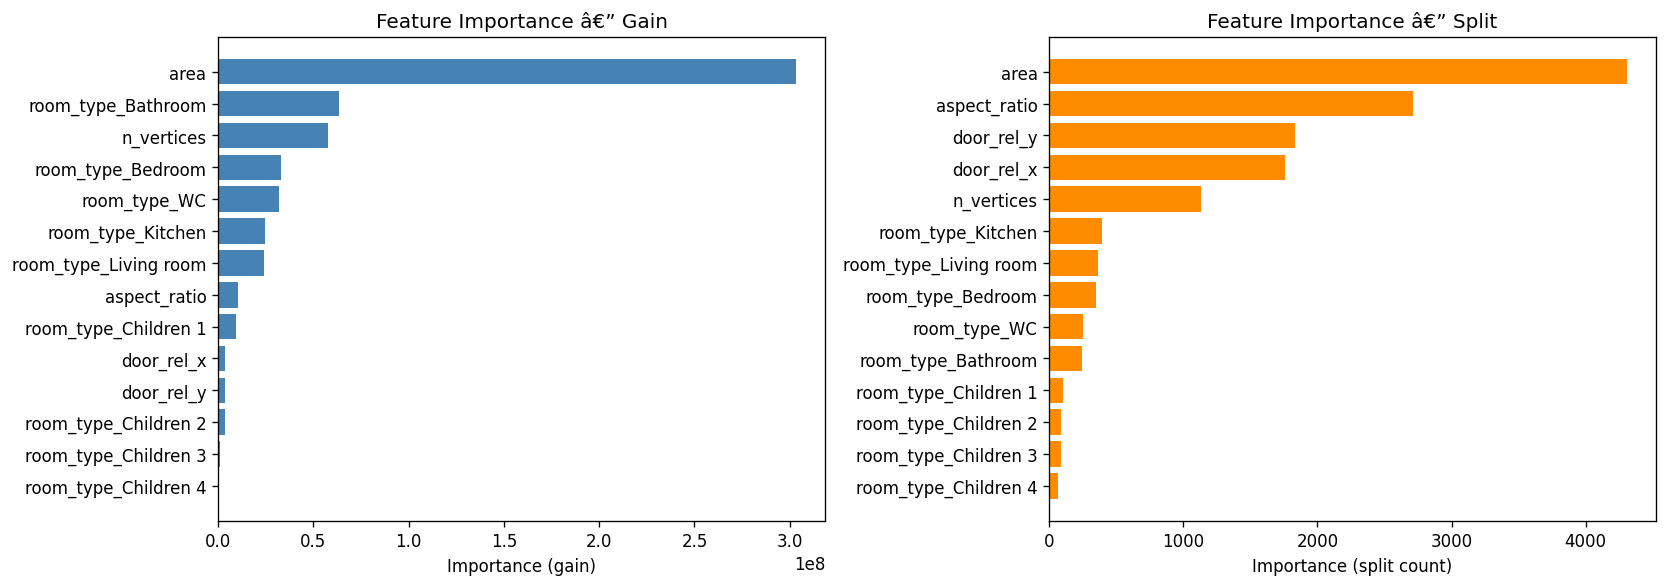

Feature importance (by gain):
  area                       gain=303330876.7  split= 4309
  room_type_Bathroom         gain=63232260.0  split=  243
  n_vertices                 gain=57493698.0  split= 1131
  room_type_Bedroom          gain=33188555.2  split=  348
  room_type_WC               gain=31687258.8  split=  250
  room_type_Kitchen          gain=24618872.9  split=  396
  room_type_Living room      gain=23948117.2  split=  362
  aspect_ratio               gain=10294625.7  split= 2711
  room_type_Children 1       gain= 9296982.7  split=  100
  door_rel_x                 gain= 3827231.2  split= 1759
  door_rel_y                 gain= 3785203.5  split= 1836
  room_type_Children 2       gain= 3766472.0  split=   91
  room_type_Children 3       gain= 1170123.3  split=   86
  room_type_Children 4       gain=  364966.1  split=   63


In [11]:
importance_gain = model.feature_importance(importance_type="gain")
importance_split = model.feature_importance(importance_type="split")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

idx_gain = np.argsort(importance_gain)
ax1.barh([FEATURE_NAMES[i] for i in idx_gain], importance_gain[idx_gain], color="steelblue")
ax1.set_xlabel("Importance (gain)")
ax1.set_title("Feature Importance â€” Gain")

idx_split = np.argsort(importance_split)
ax2.barh([FEATURE_NAMES[i] for i in idx_split], importance_split[idx_split], color="darkorange")
ax2.set_xlabel("Importance (split count)")
ax2.set_title("Feature Importance â€” Split")

plt.tight_layout()

# W&B table
imp_table = wandb.Table(
    columns=["feature", "gain", "split"],
    data=[[FEATURE_NAMES[i], float(importance_gain[i]), int(importance_split[i])]
          for i in range(len(FEATURE_NAMES))]
)
wandb.log({
    "plots/feature_importance": wandb.Image(fig),
    "feature_importance_table": imp_table,
}, commit=False)
plt.show()

print("Feature importance (by gain):")
for i in reversed(idx_gain):
    print(f"  {FEATURE_NAMES[i]:<25s}  gain={importance_gain[i]:>10.1f}  split={importance_split[i]:>5d}")

## 5. Score Bucket Analysis

How well does the model handle each score region, given the bimodal distribution?

In [12]:
def bucket_analysis(y_true, y_pred, label=""):
    buckets = {
        "Failed (=0)": y_true == 0,
        "Low (1-39)": (y_true >= 1) & (y_true <= 39),
        "Mid (40-69)": (y_true >= 40) & (y_true <= 69),
        "Good (70-89)": (y_true >= 70) & (y_true <= 89),
        "Excellent (90+)": y_true >= 90,
    }
    rows = []
    print(f"\n{label} â€” MAE by score bucket:")
    print(f"{'Bucket':<18s}  {'n':>6s}  {'%':>6s}  {'MAE':>8s}  {'Mean pred':>10s}")
    print("-" * 54)
    for name, mask in buckets.items():
        if mask.any():
            n = mask.sum()
            mae = mean_absolute_error(y_true[mask], y_pred[mask])
            mean_pred = y_pred[mask].mean()
            print(f"{name:<18s}  {n:>6d}  {n/len(y_true)*100:>5.1f}%  {mae:>8.2f}  {mean_pred:>10.2f}")
            rows.append([name, int(n), round(float(n/len(y_true)*100), 1),
                        round(mae, 2), round(float(mean_pred), 2)])
    return rows

val_rows = bucket_analysis(y_val, y_val_pred, "Validation set")
test_rows = bucket_analysis(y_test, y_test_pred, "Test set")

# W&B: score bucket table (test set)
bucket_table = wandb.Table(
    columns=["Bucket", "n", "%", "MAE", "Mean Predicted"],
    data=test_rows,
)
wandb.log({"score_bucket_analysis": bucket_table}, commit=False)


Validation set â€” MAE by score bucket:
Bucket                   n       %       MAE   Mean pred
------------------------------------------------------
Failed (=0)           1223   26.7%     13.05       11.92
Low (1-39)             143    3.1%     23.23       40.06
Mid (40-69)            278    6.1%     18.94       55.74
Good (70-89)           977   21.3%      9.33       76.08
Excellent (90+)       1951   42.6%      8.21       92.20

Test set â€” MAE by score bucket:
Bucket                   n       %       MAE   Mean pred
------------------------------------------------------
Failed (=0)           1349   29.4%     13.11       11.87
Low (1-39)             139    3.0%     24.09       45.33
Mid (40-69)            250    5.4%     17.75       58.43
Good (70-89)           952   20.7%      9.98       75.23
Excellent (90+)       1897   41.3%      8.20       92.20


## 6. Error Gallery â€” Worst Mispredictions

For each room type, show rasterized images of the 10 worst overestimates (true low, predicted high)
and 10 worst underestimates (true high, predicted low) on the test set. Logged as a W&B table
so we can browse them interactively.

In [13]:
from furnisher_surrogate.rasterize import rasterize_room
from furnisher_surrogate.features import area as compute_area, n_vertices

N_PER_DIRECTION = 10
LOW_THRESH = 30   # "true low" = actual score < 30
HIGH_THRESH = 70  # "true high" = actual score > 70

def room_to_wandb_image(room):
    """Rasterize room and return as wandb.Image with RGB composite."""
    img = rasterize_room(room)  # (3, 64, 64) uint8
    rgb = np.stack([img[0], img[1], img[2]], axis=-1)  # (64, 64, 3)
    return wandb.Image(rgb)

error_rows = []
test_rooms = rooms["test"]
errors = y_test_pred - y_test  # positive = overestimate

for rt in ROOM_TYPES:
    mask = np.array([r.room_type == rt for r in test_rooms])
    idx_rt = np.where(mask)[0]
    y_true_rt = y_test[idx_rt]
    y_pred_rt = y_test_pred[idx_rt]
    errors_rt = errors[idx_rt]

    # Overestimates: true low (< 30), sorted by largest positive error
    low_mask = y_true_rt < LOW_THRESH
    low_idx = idx_rt[low_mask]
    low_errors = errors_rt[low_mask]
    top_over = low_idx[np.argsort(-low_errors)[:N_PER_DIRECTION]]

    # Underestimates: true high (> 70), sorted by largest negative error
    high_mask = y_true_rt > HIGH_THRESH
    high_idx = idx_rt[high_mask]
    high_errors = errors_rt[high_mask]
    top_under = high_idx[np.argsort(high_errors)[:N_PER_DIRECTION]]

    for idx in top_over:
        room = test_rooms[idx]
        error_rows.append([
            rt, "overestimate", round(float(y_test[idx]), 1),
            round(float(y_test_pred[idx]), 1),
            round(float(errors[idx]), 1),
            round(compute_area(room), 1), n_vertices(room),
            room_to_wandb_image(room),
        ])

    for idx in top_under:
        room = test_rooms[idx]
        error_rows.append([
            rt, "underestimate", round(float(y_test[idx]), 1),
            round(float(y_test_pred[idx]), 1),
            round(float(errors[idx]), 1),
            round(compute_area(room), 1), n_vertices(room),
            room_to_wandb_image(room),
        ])

error_table = wandb.Table(
    columns=["Room Type", "Direction", "Actual", "Predicted", "Error",
             "Area (mÂ²)", "Vertices", "Image"],
    data=error_rows,
)
wandb.log({"error_gallery": error_table}, commit=False)

# Print summary
n_over = sum(1 for r in error_rows if r[1] == "overestimate")
n_under = sum(1 for r in error_rows if r[1] == "underestimate")
print(f"Error gallery: {n_over} overestimates + {n_under} underestimates = {len(error_rows)} rows")
print(f"\nWorst overestimates (true < {LOW_THRESH}, predicted high):")
for rt in ROOM_TYPES:
    rows_rt = [r for r in error_rows if r[0] == rt and r[1] == "overestimate"]
    if rows_rt:
        worst = max(rows_rt, key=lambda r: r[4])
        print(f"  {rt:<15s}  n={len(rows_rt):>2d}  worst: actual={worst[2]}, pred={worst[3]}, err={worst[4]:+.1f}")
    else:
        print(f"  {rt:<15s}  n= 0  (no rooms with actual < {LOW_THRESH})")

print(f"\nWorst underestimates (true > {HIGH_THRESH}, predicted low):")
for rt in ROOM_TYPES:
    rows_rt = [r for r in error_rows if r[0] == rt and r[1] == "underestimate"]
    if rows_rt:
        worst = min(rows_rt, key=lambda r: r[4])
        print(f"  {rt:<15s}  n={len(rows_rt):>2d}  worst: actual={worst[2]}, pred={worst[3]}, err={worst[4]:+.1f}")
    else:
        print(f"  {rt:<15s}  n= 0  (no rooms with actual > {HIGH_THRESH})")

Error gallery: 90 overestimates + 90 underestimates = 180 rows

Worst overestimates (true < 30, predicted high):
  Bedroom          n=10  worst: actual=0.0, pred=80.0, err=+80.0
  Living room      n=10  worst: actual=0.0, pred=75.6, err=+75.6
  Bathroom         n=10  worst: actual=0.0, pred=66.6, err=+66.6
  WC               n=10  worst: actual=0.0, pred=77.0, err=+77.0
  Kitchen          n=10  worst: actual=0.0, pred=91.4, err=+91.4
  Children 1       n=10  worst: actual=0.0, pred=70.9, err=+70.9
  Children 2       n=10  worst: actual=0.0, pred=60.3, err=+60.3
  Children 3       n=10  worst: actual=0.0, pred=53.1, err=+53.1
  Children 4       n=10  worst: actual=0.0, pred=53.1, err=+53.1

Worst underestimates (true > 70, predicted low):
  Bedroom          n=10  worst: actual=79.7, pred=21.9, err=-57.8
  Living room      n=10  worst: actual=100.0, pred=1.3, err=-98.7
  Bathroom         n=10  worst: actual=91.7, pred=43.0, err=-48.7
  WC               n=10  worst: actual=75.0, pred=17.9

## 7. Summary & Performance Floor

In [14]:
print("=" * 60)
print("BASELINE MODEL PERFORMANCE FLOOR")
print("=" * 60)
print(f"Model:           LightGBM ({optimal_rounds} rounds)")
print(f"Features:        {X_train.shape[1]} (5 numeric + 9 one-hot room type)")
print()
print(f"Test MAE:        {test_m['test/mae']:.2f}  (naive: {config['naive_mae']:.2f})")
print(f"Test RMSE:       {test_m['test/rmse']:.2f}")
print(f"Test RÂ²:         {test_m['test/r2']:.4f}")
print(f"Fail/Pass Acc:   {test_m['test/binary_accuracy']:.4f}")
print(f"Fail/Pass F1:    {test_m['test/binary_f1']:.4f}")
print()
test_mae = test_m['test/mae']
if test_mae < 15:
    interp = "MAE < 15: Geometry clearly determines score. Strong baseline."
elif test_mae > 25:
    interp = "MAE > 25: Spatial detail matters. CNN should help significantly."
else:
    interp = "15 <= MAE <= 25: Moderate baseline. CNN has room to improve."
print(f"Interpretation:  {interp}")

wandb.summary.update({
    "baseline_mae": test_mae,
    "baseline_rmse": test_m["test/rmse"],
    "baseline_r2": test_m["test/r2"],
    "improvement_over_naive": config["naive_mae"] - test_mae,
})

# Add run description for future reference
wandb.run.notes = (
    "Phase 5 baseline: LightGBM regressor on 14 tabular features "
    "(area, aspect_ratio, n_vertices, door_rel_x/y, 9 room-type one-hot). "
    f"Test MAE={test_mae:.2f} (naive={config['naive_mae']:.2f}, "
    f"{config['naive_mae'] - test_mae:.1f}pt improvement). "
    f"RÂ²={test_m['test/r2']:.3f}. "
    "Hardest: Kitchen (16.9), Living room (18.8). "
    "Easiest: Bathroom (3.1). "
    "CNN (Phase 6) must beat this."
)

# Final commit for all pending tables and images
wandb.log({}, commit=True)
wandb.finish()
print(f"\nW&B run finished.")

wandb: uploading media\images\plots\feature_importance_0_825811bd455ea5063aad.png; uploading media\table\feature_importance_table_0_97408ef969e40af26615.table.json; uploading media\table\score_bucket_analysis_0_56ba35310d4c37d583ba.table.json; uploading media\table\overall_metrics_0_c85f219d0e1bacf1c13e.table.json; uploading media\table\per_room_type_metrics_0_ec65237be6c13f43be5d.table.json (+ 4 more)


BASELINE MODEL PERFORMANCE FLOOR
Model:           LightGBM (457 rounds)
Features:        14 (5 numeric + 9 one-hot room type)

Test MAE:        11.02  (naive: 37.48)
Test RMSE:       19.15
Test RÂ²:         0.8000
Fail/Pass Acc:   0.8744
Fail/Pass F1:    0.9182

Interpretation:  MAE < 15: Geometry clearly determines score. Strong baseline.


wandb: uploading media\images\plots\pred_vs_actual_0_767415f166fff5c5e1dd.png; uploading artifact run-3t4hiefb-error_gallery


wandb: uploading artifact run-3t4hiefb-error_gallery


wandb: uploading config.yaml


wandb: uploading data


wandb: 
wandb: Run summary:
wandb:           baseline_mae 11.02348
wandb:            baseline_r2 0.80002
wandb:          baseline_rmse 19.14979
wandb:            cv/best_mae 11.12841
wandb:      cv/optimal_rounds 457
wandb: improvement_over_naive 26.45652
wandb:   test/binary_accuracy 0.8744
wandb:         test/binary_f1 0.91817
wandb:               test/mae 11.02348
wandb:      test/mae_Bathroom 3.14278
wandb:                    +26 ...
wandb: 


wandb:  View run lgbm-v1 at: https://wandb.ai/infau/furnisher-surrogate/runs/3t4hiefb
wandb:  View project at: https://wandb.ai/infau/furnisher-surrogate
wandb: Synced 4 W&B file(s), 8 media file(s), 190 artifact file(s) and 0 other file(s)


wandb: Find logs at: .\wandb\run-20260226_145011-3t4hiefb\logs



W&B run finished.
